## Homework 4

Use this notebook as a starter

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from tqdm.auto import tqdm

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [3]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [4]:
df = pd.read_csv('dataset/CreditScoring/CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [9]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
seniority    4454 non-null int64
home         4454 non-null object
time         4454 non-null int64
age          4454 non-null int64
marital      4454 non-null object
records      4454 non-null object
job          4454 non-null object
expenses     4454 non-null int64
income       4454 non-null int64
assets       4454 non-null int64
debt         4454 non-null int64
amount       4454 non-null int64
price        4454 non-null int64
default      4454 non-null int32
dtypes: int32(1), int64(9), object(4)
memory usage: 469.9+ KB


In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

numerical_cols = df.select_dtypes(include=['int64','int32']).columns.tolist()
print(numerical_cols)

['home', 'marital', 'records', 'job']
['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(round(df_train.shape[0]/df.shape[0], 2), round(df_val.shape[0]/df.shape[0], 2), round(df_test.shape[0]/df.shape[0], 2))

0.6 0.2 0.2


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [13]:
for col in numerical_cols:
    if col != "default":
        fpr, tpr, thresholds = metrics.roc_curve(df_train["default"], df_train[col])
        if round(metrics.auc(fpr, tpr),2) < 0.5:
            fpr, tpr, thresholds = metrics.roc_curve(df_train["default"], -df_train[col])
        print(col, round(metrics.auc(fpr, tpr),2))

seniority 0.71
time 0.56
age 0.57
expenses 0.5
income 0.68
assets 0.65
debt 0.5
amount 0.59
price 0.5


Which categorical variable (among the following 4) has the highest AUC?

- **seniority**
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [14]:
y_train = df_train["default"]
y_val = df_val["default"]
y_test = df_test["default"]

df_train = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
df_val = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home']]
df_test = df_test[['seniority', 'income', 'assets', 'records', 'job', 'home']]

dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [15]:
logreg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- **0.812**

In [16]:
y_train.value_counts()

0    1927
1     745
Name: default, dtype: int64

In [17]:
y_pred = logreg.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
print(round(metrics.auc(fpr, tpr), 3))

0.812


In [18]:
roc_auc_score(y_val, y_pred)

0.8120879813449298

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [19]:
y_val[:5]

3346    0
2984    0
322     1
11      0
1041    0
Name: default, dtype: int32

In [20]:
y_pred[:20]

array([0.19686443, 0.11756677, 0.26981959, 0.12327223, 0.04141662,
       0.60339597, 0.84730558, 0.23082892, 0.92015483, 0.34025945,
       0.31961661, 0.06286321, 0.4058091 , 0.40687717, 0.10194242,
       0.07069943, 0.03020164, 0.27491351, 0.79266886, 0.05239736])

In [21]:
actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

p_scores, r_scores = [], []
thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    pred_pos = (y_pred >= t)
    pred_neg = (y_pred < t)
        
    tp = (pred_pos & actual_pos).sum()
    tn = (pred_neg & actual_neg).sum()
    fp = (pred_pos & actual_neg).sum()
    fn = (pred_neg & actual_pos).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
        
    p_scores.append(p)
    r_scores.append(r)

C:\Users\DV\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  app.launch_new_instance()


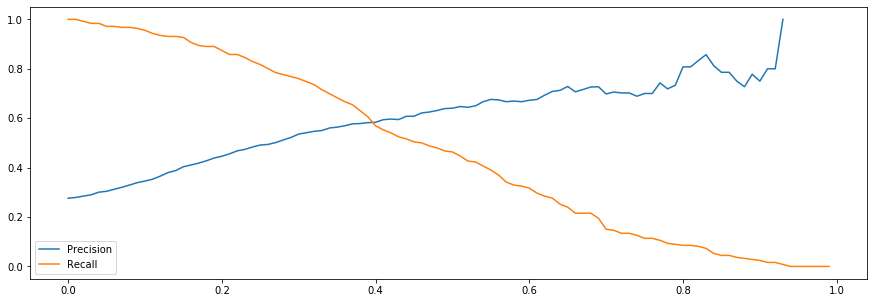

In [22]:
plt.figure(figsize=(15,5))
plt.plot(thresholds, p_scores, label="Precision")
plt.plot(thresholds, r_scores, label="Recall")
plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* **0.4**
* 0.6
* 0.8

## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [23]:
actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

f1_scores = []
thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    pred_pos = (y_pred >= t)
    pred_neg = (y_pred < t)
    
    tp = (pred_pos & actual_pos).sum()
    tn = (pred_neg & actual_neg).sum()
    fp = (pred_pos & actual_neg).sum()
    fn = (pred_neg & actual_pos).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2*((p*r)/(p+r))
    
    f1_scores.append(f1)

C:\Users\DV\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  app.launch_new_instance()


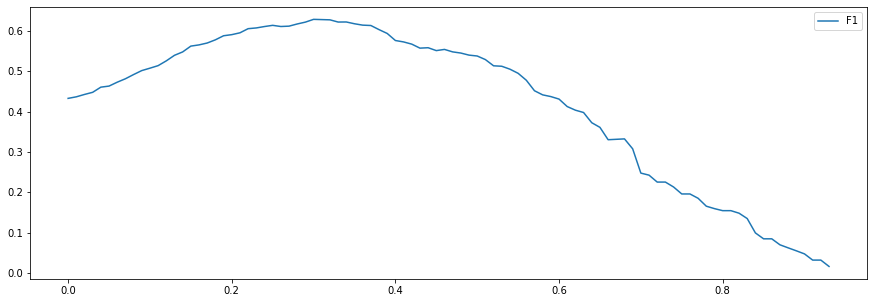

In [24]:
plt.figure(figsize=(15,5))
plt.plot(thresholds, f1_scores, label="F1")
plt.legend()
plt.show()

At which threshold F1 is maximal?

- 0.1
- **0.3**
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kf.split(df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]):
    
    df_train = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].iloc[train_idx]
    df_val = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].iloc[val_idx] 
    y_train = df_full_train["default"].iloc[train_idx]
    y_val = df_full_train["default"].iloc[val_idx]
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = logreg.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
    auc = round(roc_auc_score(y_val, y_pred), 3)
    print(auc)
    scores.append(auc)
    
print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

0.823
0.832
0.791
0.826
0.814
C=debt 0.817 +- 0.014


In [26]:
print(abs(np.diff(scores)))
print(abs(np.diff(scores)).sum())

[0.009 0.041 0.035 0.012]
0.09699999999999986


How large is standard devidation of the scores across different folds?

- 0.001
- **0.014**
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [31]:
for c in tqdm([0.01, 0.1, 1, 10]):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kf.split(df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]):

        df_train = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].iloc[train_idx]
        df_val = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].iloc[val_idx] 
        y_train = df_full_train["default"].iloc[train_idx]
        y_val = df_full_train["default"].iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.809 +- 0.013
C=0.1 0.812 +- 0.013
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


In [30]:
for c in tqdm([0.01, 0.1, 1, 10]):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kf.split(df_full_train):

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx] 
        y_train = df_full_train["default"].iloc[train_idx]
        y_val = df_full_train["default"].iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.994 +- 0.007
C=0.1 1.000 +- 0.000
C=1 1.000 +- 0.000
C=10 1.000 +- 0.000


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- **10**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.